# Imputacion sobre datos de NHANES

## Preparacion del Entorno

### Librerias

In [1]:
import janitor  # limpiar datos
import matplotlib.pyplot as plt # visualizacion de datos
import missingno    # exploracion de valores faltantes
import nhanes.load  # libreria con los datos a analizar
import numpy as np  # calculos numericos
import pandas as pd # trabajar con dataframe
import scipy.stats  # trabjar con estadisticos
import seaborn as sns   #   visualizacion estadistica
# import session_info
# sklearn contiene los modelos a utilizar
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Importar funciones personalizadas

In [2]:
# permite utilizar funciones contenidas en otro notebook
%run utils2.ipynb

### Configuracion de las graficas

In [3]:
%matplotlib inline

# tamaño de los graficos
sns.set(
    rc={
        'figure.figsize':(8, 6)
    }
)

# estilo de los graficos
sns.set_style('whitegrid')

## Preparando los Datos: National Health and Nutrition Examination Survey (NHANES)

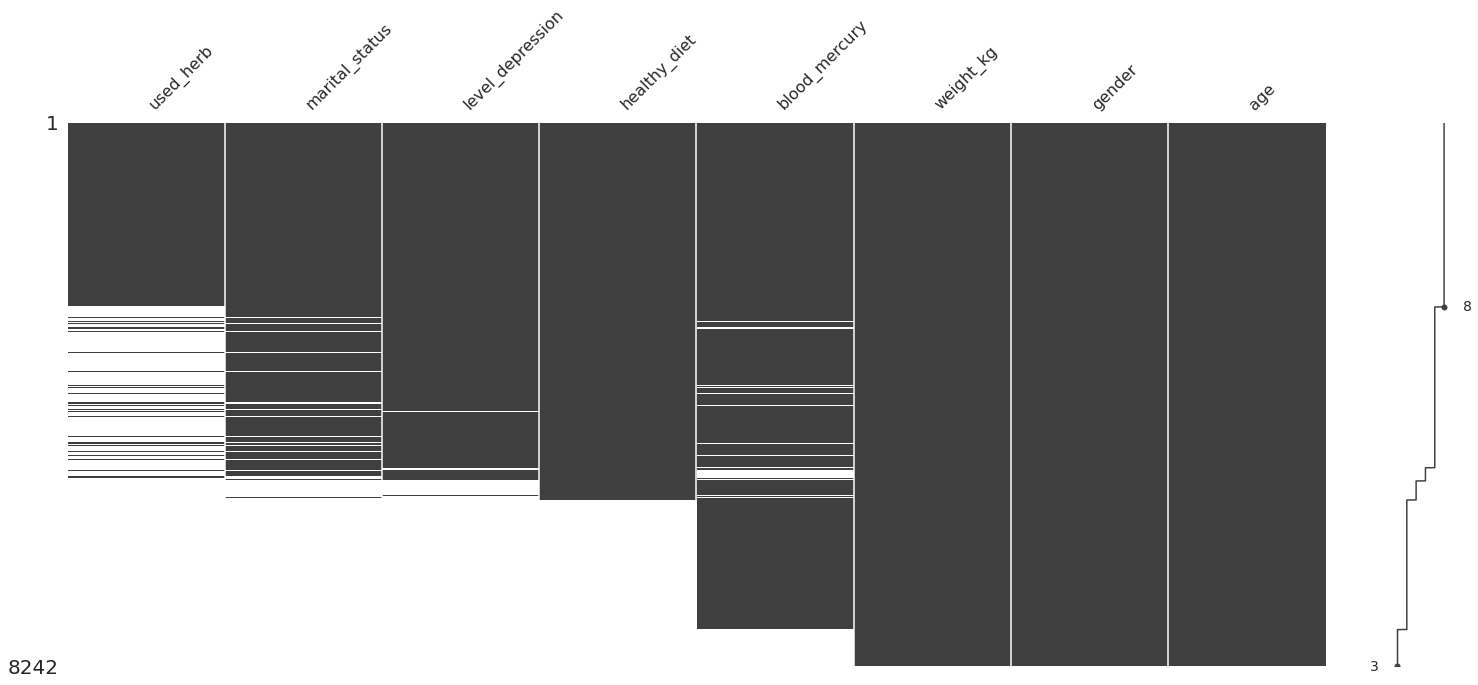

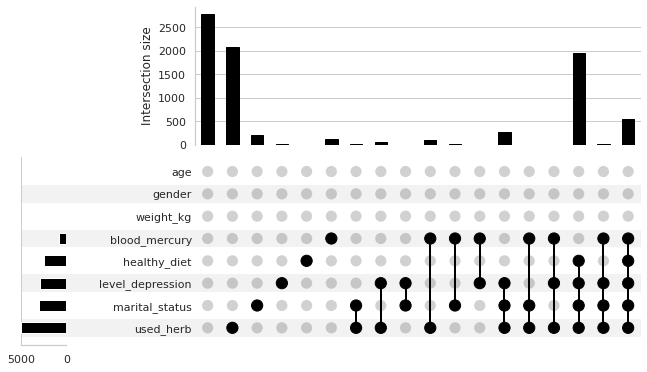

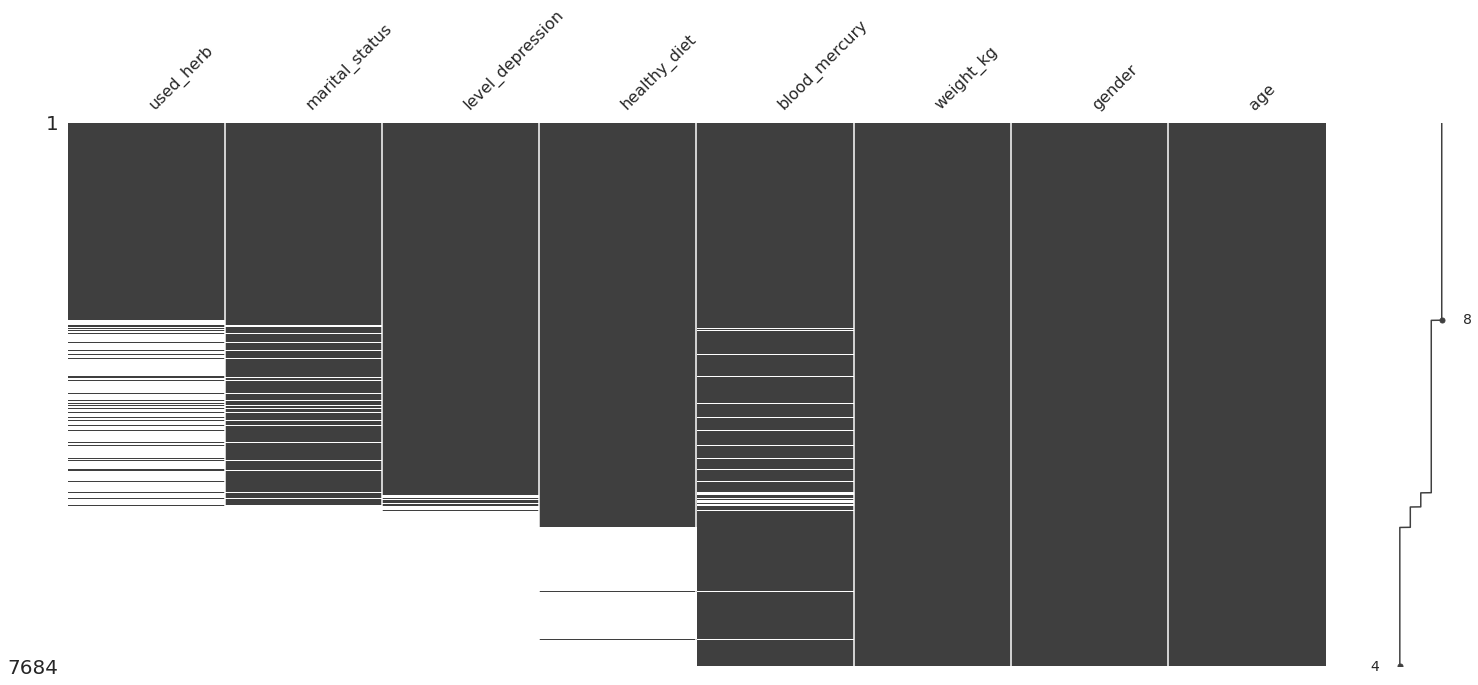

23.0 %


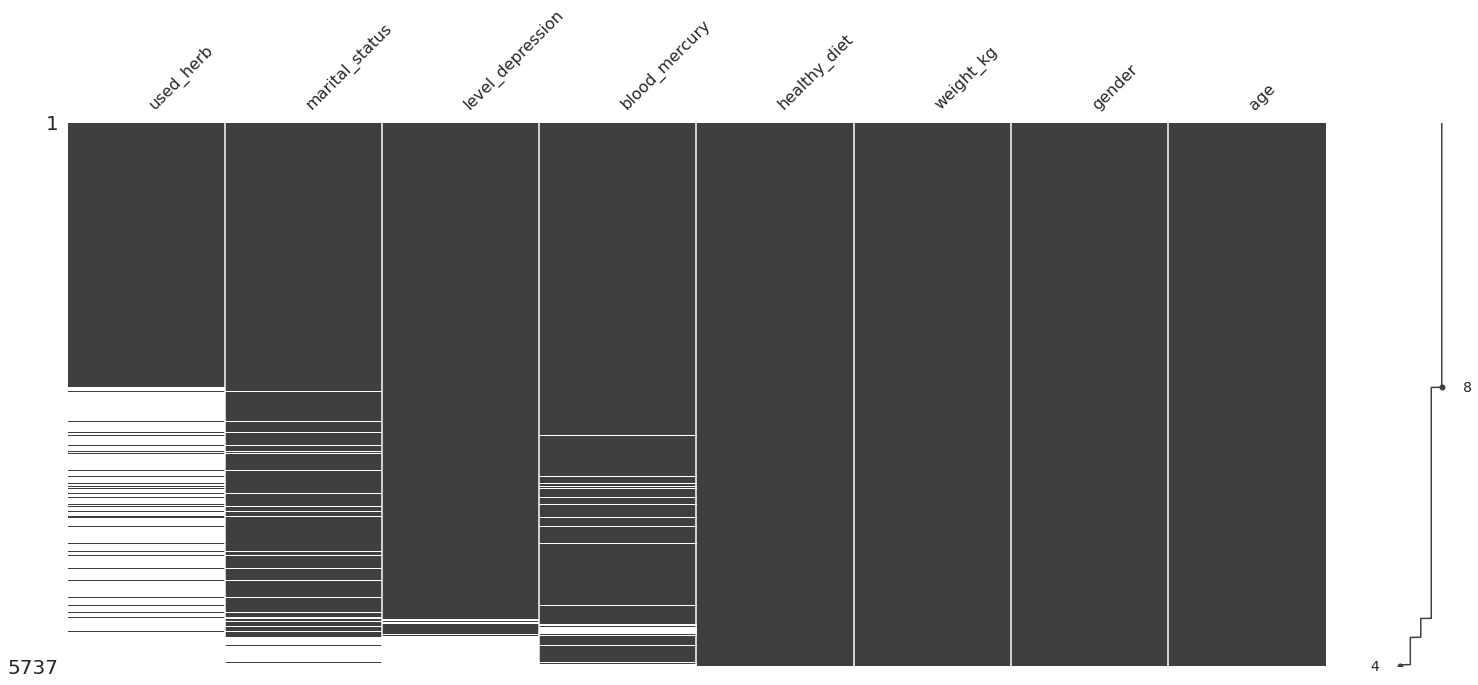

9.0 %


In [4]:
# cargar los datos externos
%run descarga_y_carga_datos.ipynb

## Analisis de los Tipos de Valores Faltantes

### Prueba de hipotesis con t-test

- Analicemos si existe alguna diferencia entre hombre y mujeres en funcion de la ausencia o presencia de valores faltantes en el consumo de hierbas.

In [5]:
# Creamos dos grupos a partir de la ausencia o precencia de missing en used_herb

female_herb, male_herb = (
    nhanes_df
    .select_columns('gender', 'used_herb') # extraer variables de interes
    .transform_column(  # transformar en booleanos los elementos de used_herb
        'used_herb',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')  # agrupar segun el genero
    .used_herb
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [6]:
# Aplicacion de la prueba t-test

# Hipotesis nula: No existe diferencia alguna entre hombres y mujeres segun los valores faltantes en used_herb
# Hipotesis alternativa: existe alguna diferencia entre hombres y mujeres segun los valores faltantes en used_herb

scipy.stats.ttest_ind(
    a = female_herb,
    b = male_herb,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.9813473437440827, pvalue=0.3264628792991634)

El valor de pvalue es de 0.32, mucho mayor al umbral de 0.05. Esto indica que no podemos rechazar la hipotesis nula, es decir, no hay suficientes pruebas que indican que haya alguna diferencia entre hombres y mujeres. La falta de respuestas en ambos grupos no es completamente al azar.

- Analicemos si existe alguna diferencia entre hombre y mujeres en funcion de la ausencia o presencia de valores faltantes en el estado marital.

In [7]:
# Creamos dos grupos a partir de la ausencia o precencia de missing en marital_status

female_status, male_status = (
    nhanes_df
    .select_columns('gender', 'marital_status')
    .transform_column(
        'marital_status',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')
    .marital_status
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [8]:
# aplicacion de la prueba t-test

# Hipotesis nula: No existe diferencia alguna entre hombres y mujeres en cuanto a la falta de respuesta de su estado marital
# Hipotesis alternativa: existe alguna diferencia entre hombres y mujeres.

scipy.stats.ttest_ind(
    a = female_status,
    b = male_status,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.7479621277949182, pvalue=0.45451367052393077)

El pvalues es mucho menor que el umbral (0.05) lo que indica que no se puede rechazar la hipotesis nula, es decir, no hay suficientes pruebas que aseguren alguna diferencia entre hombres y mujeres en cuanto a la falta de respuesta de su estado marital. La falta de respuesta no es completamente al azar.

- Analicemos si existe alguna diferencia entre hombres y mujeres en funcion de la ausencia o presencia de valores faltantes en el nivel de depresion.

In [9]:
# Creamos dos grupos a partir de la ausencia o precencia de missing en level_depression

female_depression, male_depression = (
    nhanes_df
    .select_columns('gender', 'level_depression')
    .transform_column(
        'level_depression',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')
    .level_depression
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [10]:
# aplicacion de la prueba t-test

# Hipotesis nula: No existe diferencia alguna entre hombres y mujeres en cuanto a la falta de respuesta de su nivel de depresion
# Hipotesis alternativa: existe alguna diferencia entre hombres y mujeres.

scipy.stats.ttest_ind(
    a = female_depression,
    b = male_depression,
    alternative='two-sided'
)

Ttest_indResult(statistic=-1.173376568574891, pvalue=0.2406935583186293)

El pvalue es mayor que el umbral, lo que indica que no hay suficientes pruebas para rechazar la hipotesis nula, es decir, no se puede asegurar que exista alguna diferencia entre hombres y mujeres en cuanto a la falta de respuesta de su nivel de depresion.

## Exploracion de la relacion entre variables categoricas y valores faltantes mediante un grafico de Mosaico

Este grafico trabaja con tres variables: 1 variable numerica, 1 variable categorica con solo 2 categorias y otra variable categorica. el uso de este tipos de variables asegura una optima visualizacion de las relaciones. Permite visualizar la relacion entre las tres variables dadas

### Grafico de Mosaico para gender, blood_mercury y marital_status

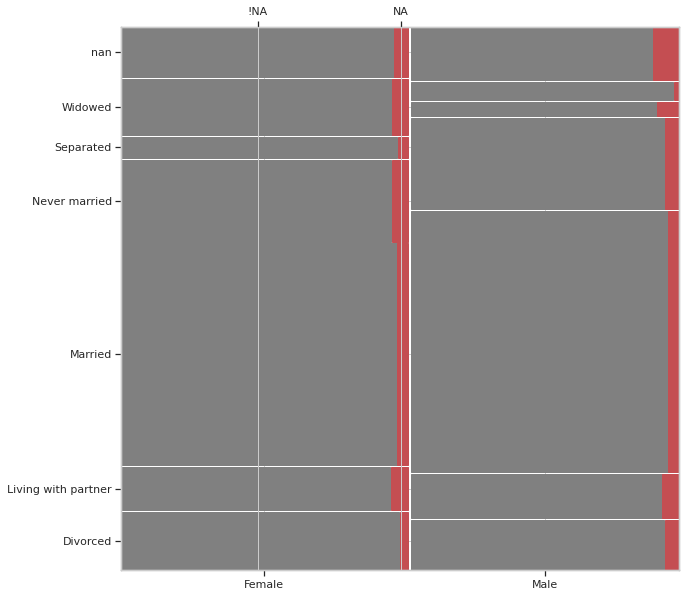

In [11]:
# variables: gender, blood_mercury, marital_status

# size de la grafica
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df
    .select_columns('blood_mercury', 'marital_status', 'gender') # selecion de variables
    .assign( # asignamos NA y !NA a los valores de blood_mercury depediendo si hay o no missing
        blood_mercury = lambda df: df.blood_mercury.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby( # cuantificar las apariciones que existen por cada combinacion de las 3 variables
        ['gender', 'marital_status', 'blood_mercury'],
        dropna=False, # no elimina los missing de marital_status
        as_index=True
    )
    .size()
    .pipe( # visualizacion con el grafico de mosaico
        lambda df: mosaic(
            data=df,
            properties= lambda key:{'color':'r' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer= lambda key:'',
            ax = ax
        )
    )
);

- La categoria 'Separado' posee pocas obervaciones tanto para hombres como para mujeres.

- Los hombres que no responden sobre su estado marital, son lo que menos dejan hacerse la prueba de mercurio en la sangre.

- Son mucho mas las mujeres viudas que los hombres. Las viudas tienden a no hacerse la prueba del mercurio en la sangre que los vuidos.

- Hay mucho mas mujeres casada que hombres.

- Las mujeres que viven con sus padres tienden a no hacerse la prueba de mercurio mucho mas que los hombres.

### Grafico de Mosaico para gender, level_depression y used_herb

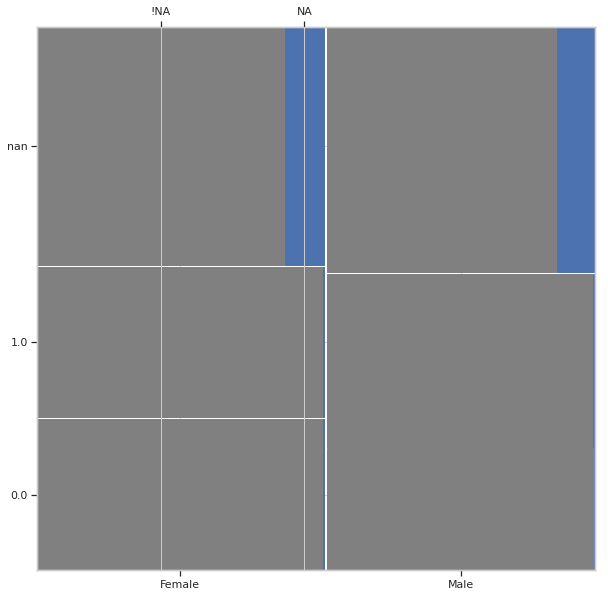

In [12]:
# variables: gender, used_herb, level_depression

# size de la grafica
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df
    .select_columns('used_herb', 'level_depression', 'gender') # selecion de variables
    .assign( # asignamos NA y !NA a los valores de blood_mercury depediendo si hay o no missing
         level_depression = lambda df: df.level_depression.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby( # cuantificar las apariciones que existen por cada combinacion de las 3 variables
        ['gender', 'used_herb', 'level_depression'],
        dropna=False, # no elimina los missing de marital_status
        as_index=True
    )
    .size()
    .pipe( # visualizacion con el grafico de mosaico
        lambda df: mosaic(
            data=df,
            properties= lambda key:{'color':'b' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer= lambda key:'',
            ax = ax
        )
    )
);

En este caso, el 1 indica que si consume hierbas, el 0 que no consume hierbas.

- Tanto hombres como mujeres que no responden sobre el consumo de hierbas, tampoco responden sobre su nivel de depression.

- Son muchos mas los hombres que consumen hierbas que las mujeres

## Codificando las variables categoricas del dataframe

## Codificacion Ordinal

Consiste en mapear cada elemento unico de texto a un numero entero. Una vez realizada la codificacion podemos comenzar el proceso de imputacion introduciendo los datos a un algoritmo de imputacion

In [13]:
# obtener las variables de tipo object y categoricas
nhanes_df.select_dtypes(include=[object, 'category'])

,marital_status,healthy_diet,gender
SEQN,,,
93705.0,Divorced,Good,Female
93706.0,NaN,Very good,Male
93708.0,Married,Excellent,Female
93709.0,Widowed,Good,Female
93711.0,Married,Very good,Male
...,...,...,...
102949.0,Living with partner,Excellent,Male
102952.0,Married,Excellent,Female
102953.0,Separated,Poor,Male


In [14]:
# obtener solo los nombres de las variables
categorical_columns = nhanes_df.select_dtypes(include=[object, 'category']).columns
categorical_columns

Index(['marital_status', 'healthy_diet', 'gender'], dtype='object')

In [15]:
# aplicamos el transformador OrdinalEncoder a las variables a traves de sklearn
# guardamos en una variable

categorical_transformer = sklearn.compose.make_column_transformer(
    #                      transformador     variables
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    # omite la aplicacion del transformador a las demas variables
    remainder='passthrough'
)

categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['marital_status', 'healthy_diet', 'gender'], dtype='object'))])

In [16]:
# dataframe transformado

(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df)
    )
)

,0,1,2,3,4,5,6,7
0,0.0,2.0,0.0,NaN,1.0,1.07,79.5,66.0
1,NaN,4.0,1.0,0.0,0.0,10.64,66.3,18.0
2,2.0,0.0,0.0,NaN,0.0,15.23,53.5,66.0
3,5.0,2.0,0.0,NaN,4.0,0.41,88.8,75.0
4,2.0,4.0,1.0,0.0,0.0,0.20,62.1,56.0
...,...,...,...,...,...,...,...,...
5732,1.0,0.0,1.0,1.0,0.0,0.20,76.9,33.0
5733,2.0,0.0,0.0,NaN,0.0,0.65,49.0,70.0
5734,4.0,3.0,1.0,0.0,1.0,0.62,97.4,42.0
5735,3.0,2.0,0.0,0.0,0.0,2.08,69.1,41.0


In [17]:
# traer los nombres de las variables al nuevo dataframe

pd.DataFrame(
    #
    categorical_transformer.fit_transform(nhanes_df),
    columns=categorical_transformer.get_feature_names_out(),
    index=nhanes_df.index
    )


,ordinalencoder__marital_status,ordinalencoder__healthy_diet,ordinalencoder__gender,remainder__used_herb,remainder__level_depression,remainder__blood_mercury,remainder__weight_kg,remainder__age
SEQN,,,,,,,,
93705.0,0.0,2.0,0.0,NaN,1.0,1.07,79.5,66.0
93706.0,NaN,4.0,1.0,0.0,0.0,10.64,66.3,18.0
93708.0,2.0,0.0,0.0,NaN,0.0,15.23,53.5,66.0
93709.0,5.0,2.0,0.0,NaN,4.0,0.41,88.8,75.0
93711.0,2.0,4.0,1.0,0.0,0.0,0.20,62.1,56.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,0.0,1.0,1.0,0.0,0.20,76.9,33.0
102952.0,2.0,0.0,0.0,NaN,0.0,0.65,49.0,70.0
102953.0,4.0,3.0,1.0,0.0,1.0,0.62,97.4,42.0


In [18]:
# los nombres de las variables ahora vienen acompanada de los prefijos 'ordinalencoder' y 'remainder'
# eliminemos estos prefijos
# guardamos el dataframe nuevo en una variable nueva

nhanes_transformed_df = (
    pd.DataFrame(
        # transformador ajustado al dataframe original
        categorical_transformer.fit_transform(nhanes_df),
        # sustituye los nombres de las variables por los del transformador
        columns=categorical_transformer.get_feature_names_out(),
        # vuelve a los indices del dataframe original
        index= nhanes_df.index 
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
)

nhanes_transformed_df

,marital_status,healthy_diet,gender,used_herb,level_depression,blood_mercury,weight_kg,age
SEQN,,,,,,,,
93705.0,0.0,2.0,0.0,NaN,1.0,1.07,79.5,66.0
93706.0,NaN,4.0,1.0,0.0,0.0,10.64,66.3,18.0
93708.0,2.0,0.0,0.0,NaN,0.0,15.23,53.5,66.0
93709.0,5.0,2.0,0.0,NaN,4.0,0.41,88.8,75.0
93711.0,2.0,4.0,1.0,0.0,0.0,0.20,62.1,56.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,0.0,1.0,1.0,0.0,0.20,76.9,33.0
102952.0,2.0,0.0,0.0,NaN,0.0,0.65,49.0,70.0
102953.0,4.0,3.0,1.0,0.0,1.0,0.62,97.4,42.0


De esta manera ya hemos convertido las variables categoricas en numericas exitosamente

## Codificacion One Hot

Consiste en crear una matriz de unos y ceros donde el 1 representa la presencia de una caracteristica o categoria de la variable de interes y 0 la ausencia de la misma. La lista se convierte en un formato ancho de manera que cada columna representa un elemento unico de nuesta categoria.

In [19]:
# creamos una copia del dataframe

nhanes_transformed_df2 = nhanes_df.copy(deep=True)

### Mediante el Metodo de Pandas

In [20]:
(
    nhanes_transformed_df2              # dataframe
    .select_columns('marital_status')   # variable categorica
    .pipe(pd.get_dummies)               # metodo de pandas
)

,marital_status_Divorced,marital_status_Living with partner,marital_status_Married,marital_status_Never married,marital_status_Separated,marital_status_Widowed
SEQN,,,,,,
93705.0,1,0,0,0,0,0
93706.0,0,0,0,0,0,0
93708.0,0,0,1,0,0,0
93709.0,0,0,0,0,0,1
93711.0,0,0,1,0,0,0
...,...,...,...,...,...,...
102949.0,0,1,0,0,0,0
102952.0,0,0,1,0,0,0
102953.0,0,0,0,0,1,0


El problema del metodo Pandas es que si lo aplicamos sobre cierta cantidad de observaciones no tomara en cuenta las demas categorias contenidas en el dataframe. En el caso anterior considera las 6 categorias de la variable. Ademas, no considera una columna para los valores faltantes. Veamos un ejemplo a continuacion: 

In [21]:
(
    nhanes_transformed_df2
    .select_columns('marital_status')
    .head(10)
    .pipe(pd.get_dummies)
)

,marital_status_Divorced,marital_status_Married,marital_status_Widowed
SEQN,,,
93705.0,1,0,0
93706.0,0,0,0
93708.0,0,1,0
93709.0,0,0,1
93711.0,0,1,0
93712.0,0,0,0
93713.0,1,0,0
93714.0,0,1,0
93715.0,0,1,0


Como vemos, para este caso solo toma en cuenta 3 categorias que nos las que aparecen en los primeros 10 registros del dataframe

### Mediante el Metodo Sklearn

In [22]:
# creamos el transformador

(   # funcion para construir los transformadores requeridos
    sklearn.compose.make_column_transformer(
        #  Transformador ordinal                 variable categorica
        (sklearn.preprocessing.OrdinalEncoder(), ['marital_status']),
        # Transformador one hot                  variable categorica
        (sklearn.preprocessing.OneHotEncoder(), ['healthy_diet']),
        # Transformador ordinal                  variable categorica
        (sklearn.preprocessing.OrdinalEncoder(), ['gender']),
        # omite las demas variables
        remainder='passthrough'
    )
)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder-1', OrdinalEncoder(),
                                 ['marital_status']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['healthy_diet']),
                                ('ordinalencoder-2', OrdinalEncoder(),
                                 ['gender'])])

In [23]:
# guardamos el transformador en una variable

transformer = (   # funcion para construir los transformadores requeridos
    sklearn.compose.make_column_transformer(
        #  Transformador ordinal                 variable categorica
        (sklearn.preprocessing.OrdinalEncoder(), ['marital_status']),
        # Transformador one hot                  variable categorica
        (sklearn.preprocessing.OneHotEncoder(), ['healthy_diet']),
        # Transformador ordinal                  variable categorica
        (sklearn.preprocessing.OrdinalEncoder(), ['gender']),
        # omite las demas variables
        remainder='passthrough'
    )
)

In [24]:
# dataframe con valores transformados

(
    pd.DataFrame(
        # transformador ajustado al dataframe original
        transformer.fit_transform(nhanes_df),
        # traer los nombres de las variables contenidos en el trasnformador
        columns=transformer.get_feature_names_out(),
        # traer los indices del dataframe original
        index=nhanes_df.index
    )
    # eliminar prefijos de los nombres
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder-1__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder-2__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('onehotencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
)

,marital_status,healthy_diet_Excellent,healthy_diet_Fair,healthy_diet_Good,healthy_diet_Poor,healthy_diet_Very good,healthy_diet_nan,gender,used_herb,level_depression,blood_mercury,weight_kg,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,1.07,79.5,66.0
93706.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,10.64,66.3,18.0
93708.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,15.23,53.5,66.0
93709.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,4.0,0.41,88.8,75.0
93711.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.20,62.1,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.20,76.9,33.0
102952.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.65,49.0,70.0
102953.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.62,97.4,42.0


In [25]:
# guardar nuevo dataframe en una nueva variable

nhanes_transformed_df2 = (
    pd.DataFrame(
        # transformador ajustado al dataframe original
        transformer.fit_transform(nhanes_df),
        # traer los nombres de las variables contenidos en el trasnformador
        columns=transformer.get_feature_names_out(),
        # traer los indices del dataframe original
        index=nhanes_df.index
    )
    # eliminar prefijos de los nombres
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder-1__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder-2__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('onehotencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
)

In [26]:
# acceder a las categorias de la variable healthy_diet con transformador one hot
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .categories_
)

[array(['Excellent', 'Fair', 'Good', 'Poor', 'Very good', nan],
       dtype=object)]

Solo se puede acceder a las categorias de las variables con transformador one hot debido a su estructura. Como las categorias de las variables con transformador ordinal estan contenida en una misma columna no tiene manera de ser accedida.

In [27]:
# extraer solo una categoria de la variable healthy_diet
# para este caso, Very good

(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .inverse_transform(
        # vector que representa la categoria Very good
        X = [[0,0,0,0,1,0]]
    )
)


array([['Very good']], dtype=object)

## Metodos de Imputacion

## 1. Imputacion de un unico valor

In [28]:
# imputacion de los valores de Mercurio en la sangre con la media

(
    nhanes_df
    # metodo de janitor
    .transform_column(
        'blood_mercury',
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
    .head(10)
)

,used_herb,marital_status,level_depression,healthy_diet,blood_mercury,weight_kg,gender,age
SEQN,,,,,,,,
93705.0,NaN,Divorced,1.0,Good,1.07,79.5,Female,66.0
93706.0,0.0,NaN,0.0,Very good,10.64,66.3,Male,18.0
93708.0,NaN,Married,0.0,Excellent,15.23,53.5,Female,66.0
93709.0,NaN,Widowed,4.0,Good,0.41,88.8,Female,75.0
93711.0,0.0,Married,0.0,Very good,0.20,62.1,Male,56.0
93712.0,1.0,NaN,1.0,Fair,0.53,58.9,Male,18.0
93713.0,NaN,Divorced,4.0,Fair,0.20,74.9,Male,67.0
93714.0,0.0,Married,1.0,Fair,1.24,87.1,Female,54.0
93715.0,NaN,Married,2.0,Poor,2.13,65.6,Male,71.0


In [29]:
# obtener la media de la variable mercurio en la sangre

nhanes_df.blood_mercury.mean()

1.3857968892954935

El valor de la media en general no se aletra, se mantiene

### Visualizacion de los valores imputados

In [30]:
# matriz de sombra para las variables blood_mercury y weight_kg

(
    nhanes_df
    .select_columns('blood_mercury', 'weight_kg')
    .missing.bind_shadow_matrix2(True, False, suffix = '_imp')
    .assign(
        blood_mercury = lambda df: df.blood_mercury.fillna(value = df.blood_mercury.mean())
    )
)

,blood_mercury,weight_kg,blood_mercury_imp,weight_kg_imp
SEQN,,,,
93705.0,1.07,79.5,False,False
93706.0,10.64,66.3,False,False
93708.0,15.23,53.5,False,False
93709.0,0.41,88.8,False,False
93711.0,0.20,62.1,False,False
...,...,...,...,...
102949.0,0.20,76.9,False,False
102952.0,0.65,49.0,False,False
102953.0,0.62,97.4,False,False


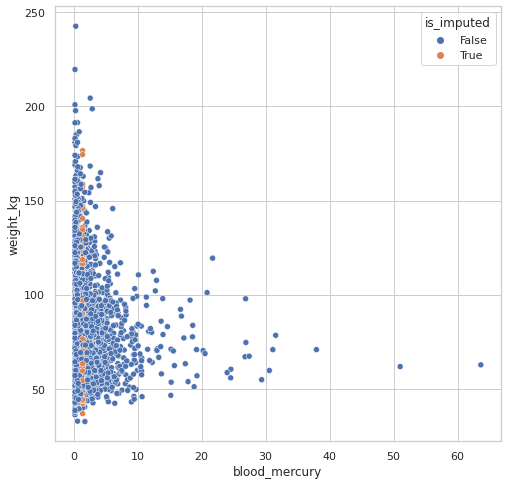

In [31]:
# visualizacion mediante un scatterplot

plt.figure(figsize=(8, 8))

(
    nhanes_df
    .select_columns('blood_mercury', 'weight_kg')
    .missing.bind_shadow_matrix2(True, False, suffix = '_imp')
    .assign(
        blood_mercury = lambda df: df.blood_mercury.fillna(value = df.blood_mercury.mean())
    )
    .missing.scatter_imputation_plot(x='blood_mercury', y='weight_kg')
);

Los valores imputados no altera la estructura de los datos por lo que se considera una buena imputacion

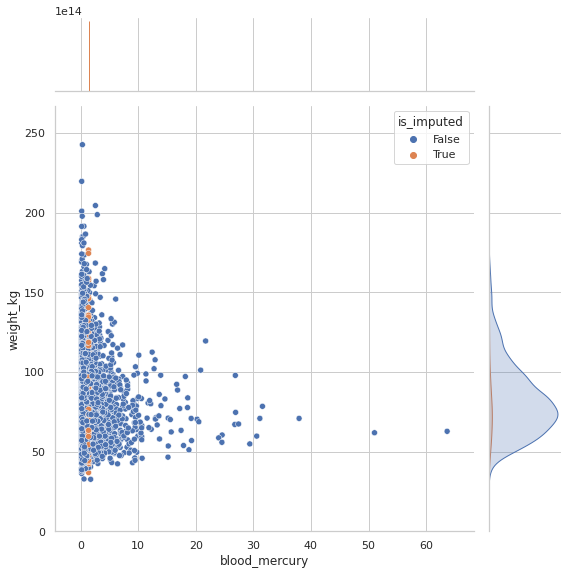

In [32]:
# visualizacion de la distribucion de los datos en el scatterplot

(
    nhanes_df
    .select_columns('blood_mercury', 'weight_kg')
    .missing.bind_shadow_matrix2(True, False, suffix = '_imp')
    .assign(
        blood_mercury = lambda df: df.blood_mercury.fillna(value = df.blood_mercury.mean())
    )
    .missing.scatter_imputation_plot(
        x='blood_mercury', 
        y='weight_kg',
        show_marginal = True,   # muestra las distribuciones a los margenes
        height = 8              # tamano del grafico
        )
);

Vemos claramente que la distribucion de los valores faltantes sigue la distribucion de los valores completos

## 2. Imputacion por llenado hacia atras y hacia adelante

Consiste en sustituir los valores faltantes con valores completos que estan antes o despues del ausente

### Llenado hacia adelante

In [35]:
# variable used_herb
# los valores faltantes se sustituyen por el valor antecesor

(
    nhanes_df
    .select_columns('used_herb', 'weight_kg')
    .fillna(method = 'ffill')
)

,used_herb,weight_kg
SEQN,,
93705.0,NaN,79.5
93706.0,0.0,66.3
93708.0,0.0,53.5
93709.0,0.0,88.8
93711.0,0.0,62.1
...,...,...
102949.0,1.0,76.9
102952.0,1.0,49.0
102953.0,0.0,97.4


In [37]:
# variable marital_status
# Metodo alternativo de llenado hacia adelante con Pandas

(
    nhanes_df
    .select_columns('marital_status', 'weight_kg')
    .ffill()
)

,marital_status,weight_kg
SEQN,,
93705.0,Divorced,79.5
93706.0,Divorced,66.3
93708.0,Married,53.5
93709.0,Widowed,88.8
93711.0,Married,62.1
...,...,...
102949.0,Living with partner,76.9
102952.0,Married,49.0
102953.0,Separated,97.4


### Llenado hacia atras

In [38]:
# variable used_herb
# Los valores faltantes se sustituyen por el valor sucesor

(
    nhanes_df
    .select_columns('used_herb', 'weight_kg')
    .fillna(method = 'bfill')
)

,used_herb,weight_kg
SEQN,,
93705.0,0.0,79.5
93706.0,0.0,66.3
93708.0,0.0,53.5
93709.0,0.0,88.8
93711.0,0.0,62.1
...,...,...
102949.0,1.0,76.9
102952.0,0.0,49.0
102953.0,0.0,97.4


In [40]:
# variable marital_status
# metodo alternativo de llenado hacia atras con Pandas

(
    nhanes_df
    .select_columns('marital_status', 'weight_kg')
    .bfill()
)

,marital_status,weight_kg
SEQN,,
93705.0,Divorced,79.5
93706.0,Married,66.3
93708.0,Married,53.5
93709.0,Widowed,88.8
93711.0,Married,62.1
...,...,...
102949.0,Living with partner,76.9
102952.0,Married,49.0
102953.0,Separated,97.4


### Imputacion dentro de dominios

In [46]:
nhanes_deck_df = (
    nhanes_df
    # seleccion de variables. Variable objetivo blood_mercury
    .select_columns('weight_kg', 'blood_mercury', 'marital_status', 'age', 'gender')
    # ordenamos las variables de acuerdo a nuestro interes
    .sort_values(
        by = ['gender', 'age', 'marital_status', 'weight_kg', 'blood_mercury'],
        ascending = True
    )
    # aplicamos la imputacion con el metodo transform
    .transform_column(
        'blood_mercury',        # variable objetivo
        lambda x: x.ffill(),    # llenado hacia adelante
        elementwise = False     # aplica para solo esa variable
    )
)

nhanes_deck_df

,weight_kg,blood_mercury,marital_status,age,gender
SEQN,,,,,
94195.0,38.6,0.20,NaN,16.0,Female
99828.0,39.3,0.84,NaN,16.0,Female
97004.0,46.7,1.88,NaN,16.0,Female
101806.0,47.6,0.20,NaN,16.0,Female
98578.0,48.0,0.35,NaN,16.0,Female
...,...,...,...,...,...
96426.0,92.1,3.27,Widowed,80.0,Male
95004.0,93.9,1.48,Widowed,80.0,Male
99990.0,97.7,1.78,Widowed,80.0,Male


In [50]:
nhanes_deck_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,weight_kg,0,5737,0.000000
1,blood_mercury,0,5737,0.000000
2,marital_status,557,5737,9.708907
3,age,0,5737,0.000000
4,gender,0,5737,0.000000


Como vemos, la variable blood_mercury queda con valores completos. Los valores imputados estan dentro de un rango dado por las demas variables categoricas lo que garantiza un mayor acercamiento a los datos reales.

## 3. Imputacion por Interpolacion

Para este caso, trabajamos un dataset con datos temporales que nos provee statsmodel 

In [51]:

airquality_df = (
    sm.datasets.get_rdataset('airquality') # datos de juguete
    .data                                  # acceder a los datos
    .clean_names(                          # limpieza de datos
        case_type = 'snake'
    )
    .add_column('year',1973)               # agregamos una columna de indicador
    .assign(                               # convertimos una variable a una fecha
        date = lambda df: pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by = 'date')              # ordenamos el df segun la fecha
    .set_index('date')                     # seteamos el indice con la fecha
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


<AxesSubplot:xlabel='date'>

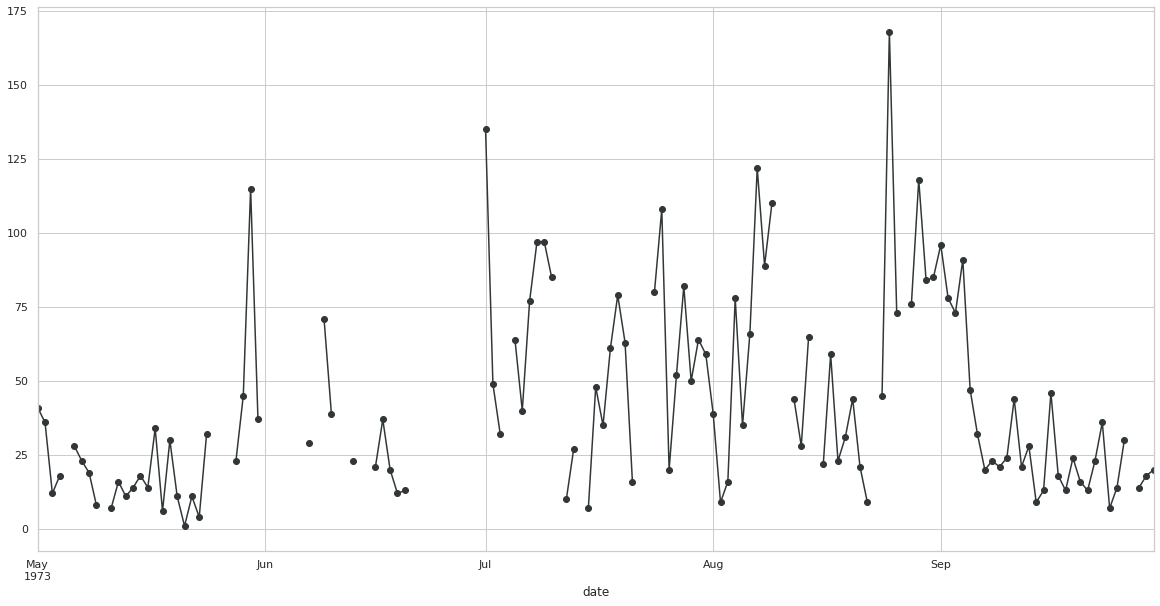

In [57]:
# Visualizacion de la variable ozono en el tiempo

plt.figure(figsize=(20,10))
(
    airquality_df                       # dataframe
    .select_columns('ozone')            # seleccionar variable objetivo
    .pipe(                              
        lambda df: (                    # grafica de la variable
            df.ozone.plot(
                color = '#313638',
                marker = 'o'
            )
        )
    )
)

La grafica nos muestra algunos puntos que no estan conectados lo que indica la presencia de valores faltantes

### Interpolacion por llenado

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

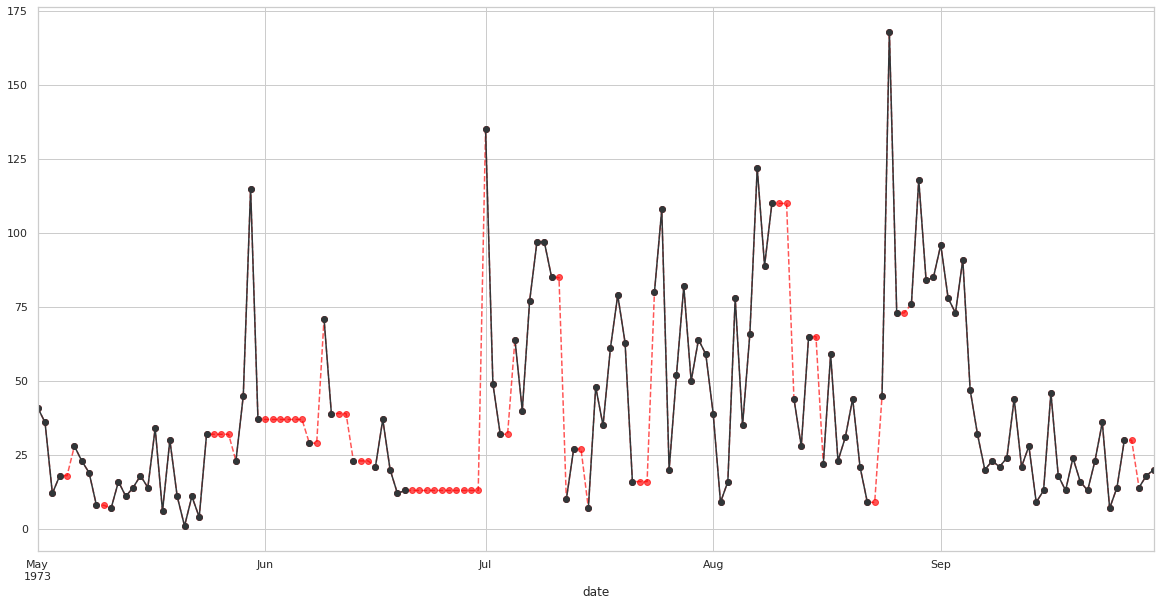

In [58]:
# imputacion por llenado hacia adelante

plt.figure(figsize=(20,10))
(
    airquality_df                   # dataframe
    .select_columns('ozone')        # variable objetivo
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(  # imputacion y grafico de ozone
                color = 'red',
                marker = 'o',
                alpha = 6/9,
                linestyle = 'dashed'
            ),
            df.ozone.plot(          # grafico de ozone
                color = '#313638',
                marker = 'o'
            )
        )
    )
)

Esta imputacion toma el valor del punto anterior y lo sustituye en el faltante que se encuentra adelante. La intewrpolacion nosigue el comportamiento de los datos.